In [1]:
import os, shutil
import tensorflow as tf


In [2]:
original_dataset_dir = '/floyd/input/skin_disease_dataset/train'

In [3]:
os.listdir('/floyd/input/skin_disease_dataset/train')

['Vascular Tumors',
 'Urticaria Hives',
 'Vasculitis Photos',
 'Exanthems and Drug Eruptions',
 'Light Diseases and Disorders of Pigmentation',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Warts Molluscum and other Viral Infections',
 'Seborrheic Keratoses and other Benign Tumors',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Lupus and other Connective Tissue diseases',
 'Acne and Rosacea Photos',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Nail Fungus and other Nail Disease',
 'Bullous Disease Photos',
 'Atopic Dermatitis Photos',
 'Eczema Photos',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Herpes HPV and other STDs Photos',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections']

In [4]:
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.resnet import  preprocess_input

In [6]:
img_width, img_height = 300, 300

In [7]:
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = preprocess_input(a)
    return a

In [8]:
res = preprocess_image("/floyd/input/skin_disease_dataset/train/Acne and Rosacea Photos/07Acne081101.jpg")
print(res)

[[[[ 8.0609970e+00  4.2210007e+00  3.1320000e+01]
   [ 1.1060997e+01  4.2210007e+00  3.2320000e+01]
   [ 2.2060997e+01  1.3221001e+01  4.1320000e+01]
   ...
   [ 2.0609970e+00 -3.7789993e+00  2.8320000e+01]
   [ 1.2060997e+01  6.2210007e+00  3.8320000e+01]
   [ 1.4060997e+01  8.2210007e+00  4.0320000e+01]]

  [[ 1.3060997e+01  9.2210007e+00  3.6320000e+01]
   [ 1.0060997e+01  3.2210007e+00  3.1320000e+01]
   [ 2.7060997e+01  1.8221001e+01  4.6320000e+01]
   ...
   [ 1.8060997e+01  1.2221001e+01  4.4320000e+01]
   [ 8.0609970e+00  2.2210007e+00  3.4320000e+01]
   [-9.3900299e-01 -8.7789993e+00  2.3320000e+01]]

  [[ 1.5060997e+01  1.1221001e+01  3.8320000e+01]
   [ 1.0060997e+01  3.2210007e+00  3.1320000e+01]
   [ 1.7060997e+01  8.2210007e+00  3.6320000e+01]
   ...
   [ 1.1060997e+01  5.2210007e+00  3.7320000e+01]
   [ 1.4060997e+01  6.2210007e+00  3.8320000e+01]
   [ 1.7060997e+01  1.0221001e+01  4.0320000e+01]]

  ...

  [[-9.3900299e-01 -4.7789993e+00  2.5320000e+01]
   [ 6.0609970e+

In [9]:
from tensorflow.keras.applications import VGG19

HEIGHT = 300
WIDTH = 300

base_model = VGG19(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/floyd/input/skin_disease_dataset/train"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        '/floyd/input/skin_disease_dataset/test',
        target_size=(300, 300),
        batch_size=BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [12]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

class_list = os.listdir("/floyd/input/skin_disease_dataset/train")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [13]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 350
BATCH_SIZE = 20
num_train_images = 15557

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(
    k=5, name='top_5'), tf.keras.metrics.TopKCategoricalAccuracy(
    k=3, name='top_3')])


checkpoint = ModelCheckpoint("vgg19.h5", monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history1 = finetune_model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=(validation_generator),
                             workers=16, 
                             steps_per_epoch=num_train_images // BATCH_SIZE,
                             validation_steps = num_train_images // BATCH_SIZE, shuffle=True, callbacks=callbacks_list)

Epoch 1/350
777/777 [==============================] - ETA: 0s - loss: 8.6692 - accuracy: 0.0771 - top_5: 0.3068 - top_3: 0.2032
Epoch 00001: saving model to vgg19.h5
777/777 [==============================] - 82s 105ms/step - loss: 8.6692 - accuracy: 0.0771 - top_5: 0.3068 - top_3: 0.2032 - val_loss: 3.1970 - val_accuracy: 0.1481 - val_top_5: 0.4190 - val_top_3: 0.3042
Epoch 2/350
777/777 [==============================] - ETA: 0s - loss: 4.1038 - accuracy: 0.0898 - top_5: 0.3177 - top_3: 0.2116
Epoch 00002: saving model to vgg19.h5
777/777 [==============================] - 85s 109ms/step - loss: 4.1038 - accuracy: 0.0898 - top_5: 0.3177 - top_3: 0.2116 - val_loss: 2.9699 - val_accuracy: 0.1472 - val_top_5: 0.4252 - val_top_3: 0.3054
Epoch 3/350
777/777 [==============================] - ETA: 0s - loss: 3.3404 - accuracy: 0.1014 - top_5: 0.3438 - top_3: 0.2371
Epoch 00003: saving model to vgg19.h5
777/777 [==============================] - 84s 109ms/step - loss: 3.3404 - accuracy: 0.

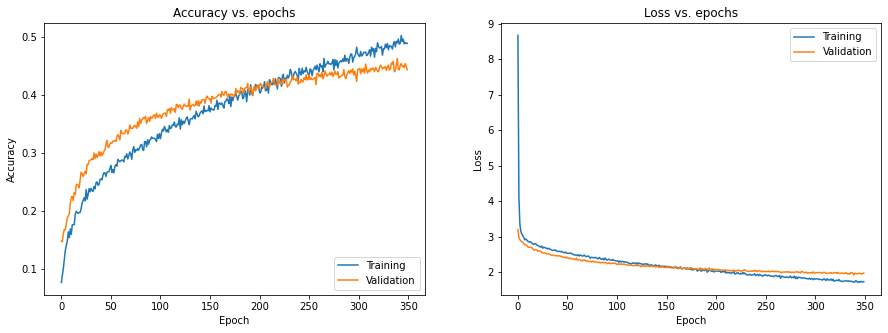

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
except KeyError:
    plt.plot(history1.history['acc'])
    plt.plot(history1.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = finetune_model.predict_generator(validation_generator, num_train_images // 31)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
matrix = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
import seaborn as sns 
p = sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix', y=1.1)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
fig.colorbar(cax)
plt.title('Confusion matrix of the classifier')